# DNN
## Deep Neural Network

In [1]:
import tensorflow as tf
from tensorflow.data import Dataset

from tensorflow.keras import layers
import pandas as pd 
import numpy as np

In [2]:
data_dir = 'sqt/pose_data'
img_height = 32
img_width = 32
batch_size = 9   # n개의 이미지만 학습

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                       # 이미지파일이 보관된 폴더
    validation_split=0.2,                # validation으로 나눌 퍼센트
    subset="training",                   # 현재 데이터세트의 타입 (training, validatrion)
    label_mode='int',                    # 라벨의 형태 (int, categorical)
    batch_size=batch_size,               # 배치사이즈
    shuffle=True,                        # 셔플 유무
    seed= 32,                             # 랜덤 시드
    image_size=(img_height, img_width),  # 이미지 크기
    color_mode='rgb',                    # 이미지 컬러채널
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 					                # 이미지 데이터가 저장된 디렉토리 경로
    validation_split=0.2,				        # 데이터의 20%를 검증 데이터셋으로 분리 
    subset="validation",				        # 분리된 데이터 중 검증 데이터셋을 선택
    seed= 32,					                # 데이터셋 분리 시 사용되는 랜덤 시드값. 동일한 결과를 재현하기 위해 사용
    image_size=(img_height, img_width),			# 로드할 이미지의 크기를 설정		
    batch_size=batch_size,
    color_mode='rgb')				        # 데이터를 몇 개의 샘플로 구성된 배치로 로드할지 설정

Found 2786 files belonging to 4 classes.
Using 2229 files for training.
Found 2786 files belonging to 4 classes.
Using 557 files for validation.


In [14]:

flatten = layers.Flatten()
dense1 = layers.Dense(64, activation="relu")
dense2 = layers.Dense(32, activation="relu")
dense3 = layers.Dense(16, activation="relu")
dense_out = layers.Dense(4)
softmax = layers.Softmax()

inputs = tf.keras.Input(shape=(32,32,3)) # shape는 데이터 개수를 의미하는 맨 앞의 축을 제외하고 입력
x = flatten(inputs)    # flatten : 하나의 차원으로 만들어준다.
x = dense1(x)
x = dense2(x)
x = dense3(x)
x = dense_out(x)
out = softmax(x)

model = tf.keras.Model(inputs=inputs, outputs=out)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() # int(인덱스) 형태의 라벨인 경우 
# complie
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                196672    
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 4)                 68        
                                                                 
 softmax_2 (Softmax)         (None, 4)                 0   

Epoch 1/20
249/249 [==============================] - 8s 28ms/step - loss: 5.2374 - accuracy: 0.3847 - val_loss: 2.7645 - val_accuracy: 0.4588
Epoch 2/20
249/249 [==============================] - 6s 22ms/step - loss: 2.2671 - accuracy: 0.4913 - val_loss: 1.7275 - val_accuracy: 0.5771
Epoch 3/20
249/249 [==============================] - 6s 23ms/step - loss: 1.7406 - accuracy: 0.5459 - val_loss: 1.6676 - val_accuracy: 0.5860
Epoch 4/20
249/249 [==============================] - 6s 23ms/step - loss: 1.5381 - accuracy: 0.5853 - val_loss: 2.3839 - val_accuracy: 0.5878
Epoch 5/20
249/249 [==============================] - 7s 25ms/step - loss: 1.3857 - accuracy: 0.6126 - val_loss: 1.3464 - val_accuracy: 0.6810
Epoch 6/20
249/249 [==============================] - 7s 26ms/step - loss: 1.3605 - accuracy: 0.6202 - val_loss: 2.2357 - val_accuracy: 0.5018
Epoch 7/20
249/249 [==============================] - 7s 27ms/step - loss: 1.3295 - accuracy: 0.6350 - val_loss: 3.0667 - val_accuracy: 0.3369

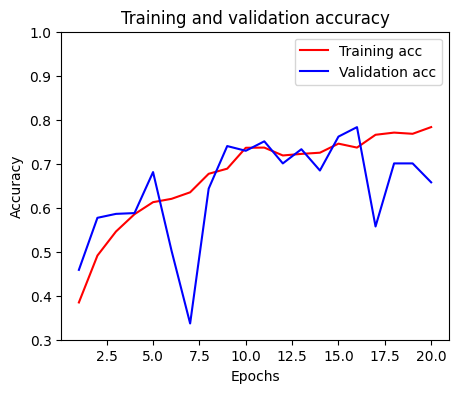

In [15]:
import matplotlib.pyplot as plt

# 모델 훈련 코드
# history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


plt.figure(figsize=(5, 4))
# 훈련과정에서의 accuracy와 validation accuracy 값을 추출합니다.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# 훈련 데이터의 accuracy 변화 추이를 그립니다.
plt.plot(epochs, acc, 'r-', label='Training acc')

# 검증 데이터의 accuracy 변화 추이를 그립니다.
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.3, 1)  # y축 범위를 0에서 1로 설정
plt.legend()
plt.savefig('Pse_DNNgraph.jpg', format='jpg', dpi=300)
plt.show()

In [ ]:
import os, re, glob
import cv2
import numpy as np
import shutil
from numpy import argmax
from keras.models import load_model

def dataization(img_path):
    img_w = 32
    img_h = 32
    #print(img_path)
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, 3)
    img = tf.image.resize(img, (32,32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

src = []
name =[]
test =[]

img_dir = 'sqt/Pi_saved_images'
for file in os.listdir(img_dir):
        src.append(os.path.join(img_dir,file))
        name.append(file)
        test.append(dataization(os.path.join(img_dir,file)))

#print(src)
print(len(name))

np.array(test)

predict = model.predict(np.array(test))
predicted_classes = np.argmax(predict, axis=1) + 1

predict

In [ ]:
predicted_classes

In [ ]:
from collections import Counter
class_counts = Counter(predicted_classes)
class_counts

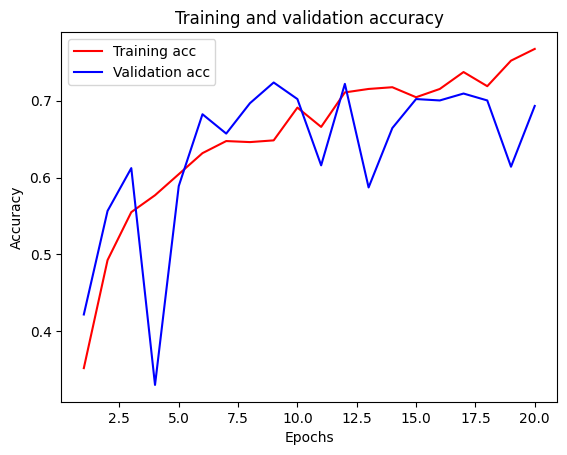

In [8]:


# 훈련과정에서의 accuracy와 validation accuracy 값을 추출합니다.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# 훈련 데이터의 accuracy 변화 추이를 그립니다.
plt.plot(epochs, acc, 'r-', label='Training acc')

# 검증 데이터의 accuracy 변화 추이를 그립니다.
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()


# DBN
## Deep Belief Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# RBM 층을 만드는 함수
def rbm_layer(hidden_units, activation):
    return layers.Dense(hidden_units, activation=activation)

# DBN 모델 생성 함수
def create_dbn_model(input_shape, rbm_units, output_units):
    model = models.Sequential()
    # RBM 층 추가
    for units in rbm_units:
        model.add(rbm_layer(units, activation='sigmoid'))  # RBM에는 시그모이드 활성화 함수 사용
    # 최종 분류 층
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

# RBM 층의 단위 및 출력 단위 정의
rbm_units = [64, 128]  # RBM의 은닉 단위 예시
output_units = 4  # 클래스 수

# DBN 모델 생성
dbn_model = create_dbn_model(input_shape=(img_height * img_width * 3,), rbm_units=rbm_units, output_units=output_units)

# 모델 빌드
dbn_model.build((None, img_height, img_width, 3))

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
dbn_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 훈련
history = dbn_model.fit(train_ds, epochs=20, validation_data=val_ds)

# 모델 평가
loss, accuracy = dbn_model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


# ANN
## Artificial Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 201,092
Trainable params: 201,092
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
248/248 [==============================] - 6s 22ms/step - loss: 46.8277 - accuracy: 0.3728 - val_loss: 11.7580 - val_accuracy: 0.4147
Epoch 2/20
248/248 [=================

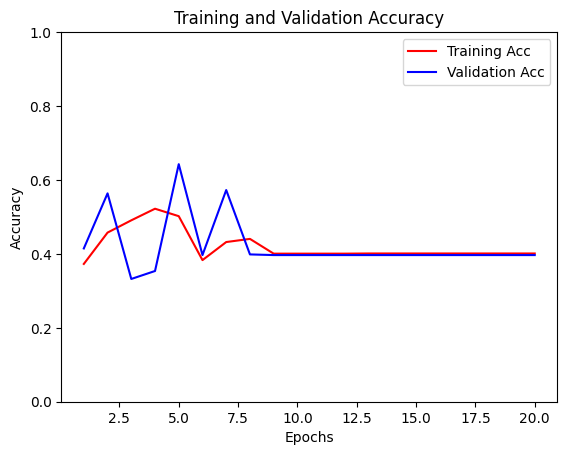

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ANN 모델 생성
ann_model = models.Sequential([
    layers.Flatten(input_shape=(img_height, img_width, 3)),  # 이미지를 1차원으로 펼치기
    layers.Dense(64, activation='relu'),  # 은닉층: 128개의 뉴런과 활성화 함수로 ReLU 사용
    layers.Dense(64, activation='relu'),   # 은닉층: 64개의 뉴런과 활성화 함수로 ReLU 사용
    layers.Dense(4, activation='softmax')  # 출력층: 클래스 수만큼의 뉴런과 활성화 함수로 softmax 사용
])

# 모델 컴파일
ann_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# 모델 요약 출력
ann_model.summary()

# 모델 훈련
history = ann_model.fit(train_ds, epochs=20, validation_data=val_ds)

# 훈련 및 검증 정확도 추출
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# 모델 평가
test_loss, test_accuracy = ann_model.evaluate(val_ds)
print("Test Accuracy:", test_accuracy)

# 그래프 그리기
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'r', label='Training Acc')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)  # y축 범위를 0에서 1로 설정
plt.savefig('ANNgraph.jpg', format='jpg', dpi=300)
plt.show()


# 